In [3]:
import probe
import pandas as pd
%matplotlib inline

## Doubleton sharing

Lets look at doubleton sharing as a measure of population structure.

In [4]:
# Read metadata 
metadata = pd.read_csv("../../config/metadata.tsv", sep="\t")

<AxesSubplot:>

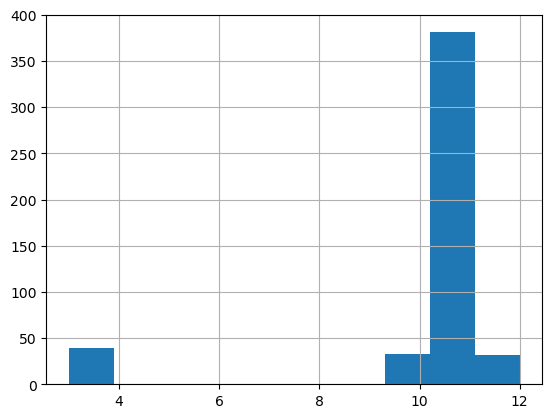

In [15]:
metadata['month'].hist()

In [5]:
contigs = ['2L', '2R', '3R', '3L', 'X']
snps = {}
pos = {}

for contig in contigs:
    # Load Arrays
    snps[contig], pos[contig] = probe.loadZarrArrays(genotypePath=f"../../resources/snp_genotypes/all/1244-VO-GH-YAWSON-VMF00149/{contig}/calldata/GT", 
                                             positionsPath=f"../../resources/snp_genotypes/all/sites/{contig}/variants/POS/",
                                             siteFilterPath=f"../../resources/site_filters/dt_20200416/gamb_colu/{contig}/variants/filter_pass/")
                                        

    ac = snps[contig].count_alleles()
    seg = ac.is_segregating()
    snps[contig] = snps[contig].compress(seg, axis=0)
    pos[contig] = pos[contig][seg]


KeyboardInterrupt: 

In [8]:
cohorts = getCohorts(metadata, columns=['species_gambiae_coluzzii', 'location'], minPopSize=5)
cohorts.head(2)

,species_gambiae_coluzzii,location,indices,cohortText,cohortNoSpaceText,colour
0,coluzzii,Adansi Apagya,"[63, 64, 65, 66, 67, 68, 69, 70, 238, 239, 240...",coluzzii | Adansi Apagya,coluzzii.AdansiApagya,#e41a1c
1,coluzzii,Adansi-Krom,"[20, 21, 22, 178, 372, 373]",coluzzii | Adansi-Krom,coluzzii.Adansi-Krom,#e41a1c


Lets first count alleles and find some doubletons! 

In [9]:
def is_variant01(gn, allele):
    return((gn == allele).any())

def checkSampleID(x, metadata=metadata):
    name = metadata.loc[x,'partner_sample_id']
    return(name)

In [10]:
pos_dbltons = {}
inds_dbltons = {}

for contig in contigs:
    log(contig)
    ac = snps[contig].count_alleles()
    doubletons_bool = ac.is_doubleton(allele=1).compute() # Need to do for each allele
    geno = snps[contig].compress(doubletons_bool, axis=0)
    log("Recorded dblton loc")
    pos_dbltons[contig] = pos[contig][doubletons_bool]
    
    n_doubletons = doubletons_bool.sum()
    log(n_doubletons)
    log("locating dblton sharers")

    
    # get 1 hets and 1 homs to each ind of the genotype data
    res = geno.is_het(1).compute()
    res2 = geno.is_hom(1).compute()
    
    dbhets = res.sum()
    dbhoms = res2.sum()
    totdbinds = dbhets + (2*dbhoms)
    log(dbhets, dbhoms, totdbinds)
    assert (n_doubletons*2) == totdbinds, "Unequal individual samples v n_dbltons!!!"
    
    res = np.logical_or(res, res2)
    # and use np where to get indices. Pandas apply is fast.
    pairs = pd.DataFrame(res).apply(np.where, axis=1).apply(np.asarray).apply(lambda x: x.flatten())
    hom_filter = pairs.apply(len) == 2
    pos_dbltons[contig] = pos_dbltons[contig][hom_filter]
    pairs = pairs[hom_filter]
    
    #make 1d array into two column pd df
    log("organising arrays")
    idxs = pd.DataFrame(np.vstack(pairs.values))
    dblton = pd.DataFrame(np.vstack(pairs.values), columns=['partner_sample_id','partner_sample_id2'])
    # shouldnt be any but remove hom/homs
    dblton = dblton.query("partner_sample_id != partner_sample_id2").reset_index(drop=True)
    dblton = dblton.applymap(checkSampleID) #store WA-XXXX ID
    inds_dbltons[contig] = pd.concat([idxs, dblton], axis=1)
    inds_dbltons[contig]['pos'] = pos_dbltons[contig]

2L
Recorded dblton loc
443355
locating dblton sharers
879396 3657 886710
organising arrays
2R
Recorded dblton loc
581119
locating dblton sharers
1152606 4816 1162238
organising arrays
3R
Recorded dblton loc
621527
locating dblton sharers
1231524 5765 1243054
organising arrays
3L
Recorded dblton loc
445171
locating dblton sharers
881760 4291 890342
organising arrays
X
Recorded dblton loc
214294
locating dblton sharers
418606 4991 428588
organising arrays


We have our SNPs that are doubletons. Now we just need to get the indices of the individuals who share those doubletons. 

In [11]:
dblton = pd.concat(inds_dbltons).reset_index().drop(columns=['level_1']).rename(columns={'level_0':'contig', 0:'idx1', 1:'idx2'})

Merge with the metadata to get lats, longs

Merge again with renamed metadata to get lats and longs for the second column

In [14]:
dblton = dblton.merge(metadata[['partner_sample_id', 'latitude', 'longitude']])
dblton = dblton.merge(metadata.rename(columns={'partner_sample_id':'partner_sample_id2', 
                                      'latitude': 'latitude2', 
                                      'longitude':  'longitude2'})[['partner_sample_id2', 'latitude2', 'longitude2']])
dblton = dblton.sort_values(by=['contig', 'pos']).reset_index(drop=True)
#Write to CSV

## READ CSV

In [6]:
#dblton.to_csv("../../results/f2variantPairs.tsv", sep="\t", index=None)
dblton = pd.read_csv("../../results/f2variantPairs.tsv", sep="\t")

In [7]:
# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


Draw histogram of doubletons shared by distance.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

/home/sanj/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


LinregressResult(slope=-0.01848771703074296, intercept=34.07647208548889, rvalue=-0.06792953777609327, pvalue=4.553455319950537e-120, stderr=0.0007925842643655427, intercept_stderr=0.056150404581477076)

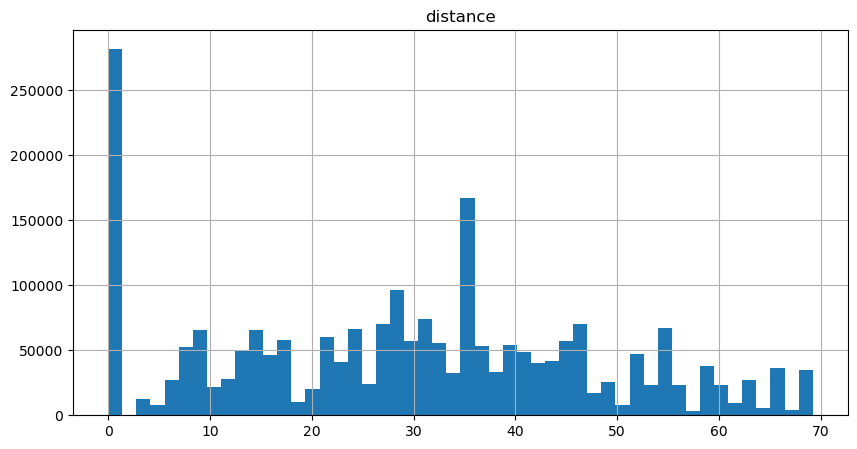

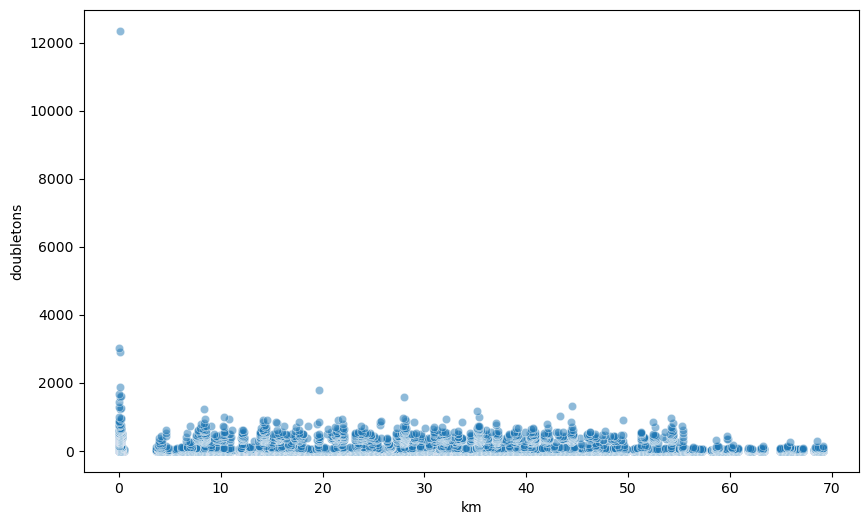

In [17]:
dblton['distance'] = haversine(dblton['latitude'], dblton['longitude'], dblton['latitude2'], dblton['longitude2'])
dblton.hist("distance", bins=50, figsize=[10,5])
#Now we need a list of every possible distance from point to point in the dataset.
coords = metadata[['latitude', 'longitude']].to_numpy()
coord_list = [] 

for x,y in itertools.combinations(coords, 2):
    
    coord_list.append([x,y])

names_list = []

for x,y in itertools.combinations(metadata['partner_sample_id'], 2):
    
    names_list.append([x,y])

names_list = np.array(names_list)
coord_list = np.array(coord_list)

assert len(names_list) == len(coord_list)
km_list = haversine(coord_list[:,0,0], coord_list[:,0,1], coord_list[:,1,0], coord_list[:,1,1])
metadata_coords = pd.DataFrame({"partner_sample_id":names_list[:,0], 
                                "partner_sample_id2": names_list[:,1], 
                                "latitude": coord_list[:,0,0], 
                                "longitude": coord_list[:,0,1], 
                                "latitude2": coord_list[:,1,0], 
                                "longitude2": coord_list[:,1,1], 
                                "km":km_list})

metadata_coords
dblton_meta = dblton.groupby(['partner_sample_id', 'partner_sample_id2']).count().reset_index().drop(columns=['latitude', 'longitude', 'latitude2', 'longitude2', 'contig', 'idx1', 'idx2', 'pos'])
dblton_meta = dblton_meta.rename(columns={'distance': 'doubletons'})
dblton_meta = metadata_coords.merge(dblton_meta, how='left').fillna(0)
dblton_meta = dblton_meta.sort_values(by='doubletons')

plt.figure(figsize=[10,6])
sns.scatterplot(dblton_meta['km'], dblton_meta['doubletons'], alpha=0.5)
import scipy
res = scipy.stats.linregress(dblton_meta['doubletons'], dblton_meta['km'])
res
#How about if we remove doubleton sharing from the same site?

In [18]:
dblton

,contig,idx1,idx2,partner_sample_id,partner_sample_id2,pos,latitude,longitude,latitude2,longitude2,distance
0,2L,141,348,WA-2145,WA-2358,2393,6.049,-1.961,6.254,-1.841,26.374450
1,2L,39,334,WA-2042,WA-2344,5819,6.370,-1.461,6.207,-1.692,31.310751
2,2L,56,223,WA-2059,WA-2230,5887,6.058,-1.390,6.058,-1.390,0.000000
3,2L,134,282,WA-2138,WA-2292,6212,6.049,-1.963,5.970,-1.779,22.162660
4,2L,210,406,WA-2217,WA-2419,8221,6.089,-1.516,6.059,-1.392,14.110739
...,...,...,...,...,...,...,...,...,...,...,...
2281941,X,196,251,WA-2203,WA-2258,24389924,6.371,-1.462,6.085,-1.697,41.062547
2281942,X,233,234,WA-2240,WA-2241,24389976,6.059,-1.392,6.059,-1.392,0.000000
2281943,X,421,466,WA-2434,WA-2481,24390066,5.970,-1.697,6.047,-1.961,30.423819
2281944,X,0,78,WA-2001,WA-2081,24390277,6.304,-1.681,5.970,-1.697,37.181208


In [24]:
x = dblton_meta.query("km > 0.5")
res2 = scipy.stats.linregress(x['doubletons'], x['km'])
res2

LinregressResult(slope=0.005147820736304177, intercept=35.79887108568369, rvalue=0.02575583142057137, pvalue=1.296215101688952e-17, stderr=0.0006024037456376602, intercept_stderr=0.05453990222098363)

### Find doubletons shared per cohort and proportions

In [26]:
loc1 = metadata[['partner_sample_id', 'location', 'species_gambiae_coluzzii']]
loc2 = loc1.rename(columns={'partner_sample_id':'partner_sample_id2', 'location':'location2', 'species_gambiae_coluzzii': 'species2'})
dblton_meta = dblton_meta.merge(loc1).merge(loc2)
dblton_meta['cohort1'] = dblton_meta['species_gambiae_coluzzii'] + " | " + dblton_meta['location']
dblton_meta['cohort2'] = dblton_meta['species2'] + " | " + dblton_meta['location2']
coh = cohorts['cohortText']

In [30]:
mask1 = dblton_meta.cohort1.isin(coh)
mask2 = dblton_meta.cohort2.isin(coh)
dblton_meta = dblton_meta.query("@mask1 & @mask2")
dblton_tots = dblton_meta.groupby(['cohort1', 'cohort2']).agg({'doubletons':'sum'}).reset_index()
dblton_sq = dblton_tots.pivot('cohort1', 'cohort2', 'doubletons')
dblton_sq.update(dblton_sq.T)
dblton_norm = dblton_sq.div(dblton_sq.sum(axis=1), axis=0)
plotRectangular(dblton_norm, path="../../results/doubletonPlot.png", annot=False)
## Getting the length of shared haplotypes in doubleton sharers